# Análise de Componentes Principais com dados de Seguro Rural

## Importando as bibliotecas

In [1]:
!pip install geopandas==0.8.1
!pip install --upgrade pyshp
!pip install shapely==1.7.0
!pip install jenkspy
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 962 kB 5.3 MB/s 
     |████████████████████████████████| 6.3 MB 1.9 MB/s 
     |████████████████████████████████| 16.7 MB 472 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 1.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.8.2
    Uninstalling Shapely-1.8.2:
      Successfully uninstalled Shapely-1.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
import jenkspy

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches, colors
from matplotlib.lines import Line2D
from matplotlib.collections import EventCollection
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection  
from matplotlib import rcParams
import matplotlib.image as mpimg
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline
# sns.set(style='whitegrid', palette='pastel') 
#sns.set(style='white', palette='deep') 
mpl.rcdefaults()

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler 

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

import shapefile
from google.colab import drive, files

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


## Funções

In [4]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

In [5]:
def cluster_metrics(data, affinity=None, linkage=None, algorithm='kmeans'):
    SQDG = {}
    KHS = {}
    DBS = {}
    SS = {}
    for k in range(2, 10):
        if algorithm == 'kmeans':
            model = KMeans(n_clusters=k, max_iter=1000).fit(data)
            SQDG[k] = round(model.inertia_, 2)
        else:
            model = AgglomerativeClustering(n_clusters=k, affinity=affinity, linkage=linkage).fit(data)
        KHS[k] = round(metrics.calinski_harabasz_score(data, model.labels_),2)
        DBS[k] = round(davies_bouldin_score(data, model.labels_),2)
        SS[k] =  round(metrics.silhouette_score(data, model.labels_, metric='euclidean'),2)
        result_metrics = pd.DataFrame((KHS, DBS, SS, SQDG), index = ['KHS', 'DBS', 'SS', 'SQDG']).T 
    return result_metrics, model

In [6]:
def plot_dendrogram(model, max_d=0):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    fig, ax = plt.subplots(figsize=(15, 7))
    ax = dendrogram(linkage_matrix,
                    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
                    p=5,  # quantos passos mostrar
                    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
                    leaf_rotation=90., # rotação
                    leaf_font_size=10., # tamanho da fonte
                    labels=dados.index, # rótulos do eixo x
                    show_contracted=True,  # to get a distribution impression in truncated branches,
                    above_threshold_color='black',
                    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
                    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
                    )
    plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
    plt.xlabel('Município')
    plt.ylabel('Distância');

In [7]:
def moran_hot_cold_spots(moran_loc, p=0.05):
    sig = 1 * (moran_loc.p_sim < p)
    HH = 1 * (sig * moran_loc.q == 1)
    LL = 3 * (sig * moran_loc.q == 3)
    LH = 2 * (sig * moran_loc.q == 2)
    HL = 4 * (sig * moran_loc.q == 4)
    cluster = HH + LL + LH + HL
    return cluster

In [8]:
color_list = ["#fde725", "#31688e", "#35b779", "#440154", "lightgrey"]

In [9]:
def mask_local_auto(moran_loc, p=0.5):
    
    # create a mask for local spatial autocorrelation
    cluster = moran_hot_cold_spots(moran_loc, p)

    cluster_labels = ['não significativo', 'AA', 'BA', 'BB', 'AB']
    labels = [cluster_labels[i] for i in cluster]

    colors5 = {0: 'lightgrey',
               1: '#fde725', # #d7191c
               2: '#21918c', # #abd9e9
               3: '#3b528b', # #2c7bb6
               4: '#5ec962'} # #fdae61
    colors = [colors5[i] for i in cluster]  # for Bokeh
    # for MPL, keeps colors even if clusters are missing:
    x = np.array(labels)
    y = np.unique(x)

    colors5_mpl = {'AA': '#fde725', # #d7191c 
                   'BA': '#21918c', # #abd9e9
                   'BB': '#3b528b', # #2c7bb6 
                   'AB': '#5ec962', # #fdae61 
                   'não significativo': 'lightgrey'}  # 
    colors5 = [colors5_mpl[i] for i in y]  # for mpl

    # HACK need this, because MPL sorts these labels while Bokeh does not
    cluster_labels.sort()
    return cluster_labels, colors5, colors, labels

def lisa_cluster(moran_loc, gdf, p=0.05, ax=None,
                 legend=True, legend_kwds=None, **kwargs):

    # retrieve colors5 and labels from mask_local_auto
    _, colors5, _, labels = mask_local_auto(moran_loc, p=p)

    # define ListedColormap
    hmap = colors.ListedColormap(colors5)

    if ax is None:
        figsize = kwargs.pop('figsize', None)
        fig, ax = plt.subplots(1, figsize=figsize)
    else:
        fig = ax.get_figure()

    gdf.assign(cl=labels).plot(column='cl', categorical=True,
                               k=2, cmap=hmap, linewidth=0, ax=ax,
                               edgecolor='white', legend=False, # tirei a legenda aqui 
                               legend_kwds=legend_kwds, **kwargs)
    ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.3)) # Adiciona linha dos estados 
    ax.set_axis_off()
    ax.set_aspect('equal')
    return fig, ax

In [10]:
def plot_metrics(result, algorithm=None):
    plt.figure(figsize=[15,7])
    if algorithm == 'kmeans':
        plt.plot(result[0].SQDG, label = 'SQDG')
    plt.plot(result[0].KHS, label = 'Calinski Harabasz Score')
    plt.plot(result[0].DBS, label= 'Davies Bouldin Score')
    plt.plot(result[0].SS, label = 'Solhouette Score')
    plt.xlabel('Número de grupos (k)')
    plt.ylabel('SQDG')
    plt.legend();

In [11]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley,s=30, edgecolors='black', linewidths=.7)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.8)
        if labels is None:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1.1, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1.1, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    ax.set(xlim=(None, 0.75), ylim=(None, 0.7))
    plt.grid()


In [12]:
img=mpimg.imread('/content/drive/My Drive/Mestrado/Imagens/rosa_dos_ventos_3.png')
img2=mpimg.imread('/content/drive/My Drive/Mestrado/Imagens/rosa_dos_ventos_p.png')

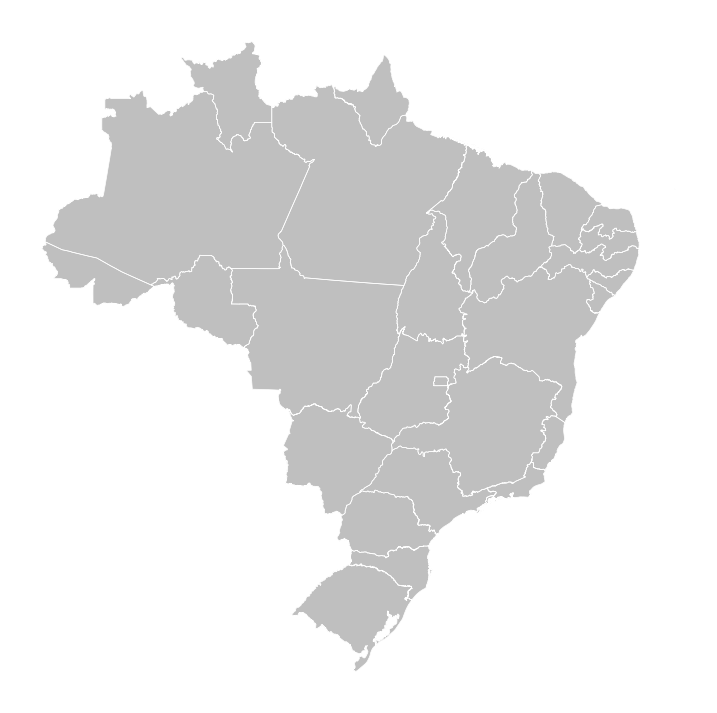

In [13]:
#Regioes geograficas
sf = shapefile.Reader('/content/drive/My Drive/Mestrado/Dados/estados/estados_2010.shp')
shapes = sf.shapes()
Nshp = len(shapes)

ptchs   = []
for nshp in range(Nshp):
    pts     = np.array(shapes[nshp].points)
    prt     = shapes[nshp].parts
    par     = list(prt) + [pts.shape[0]]

    for pij in range(len(prt)):
       ptchs.append(Polygon(pts[par[pij]:par[pij+1]]))

#UF
sf_uf = shapefile.Reader('/content/drive/My Drive/Mestrado/Dados/estados/estados_2010.shp')
shapes = sf.shapes()
shapes_uf = sf_uf.shapes()
Nshp_uf = len(shapes_uf)

ptchs_uf   = []
for nshp_uf in range(Nshp_uf):
    pts_uf     = np.array(shapes_uf[nshp_uf].points)
    prt_uf     = shapes_uf[nshp_uf].parts
    par_uf     = list(prt_uf) + [pts_uf.shape[0]]

    for pij_uf in range(len(prt_uf)):
       ptchs_uf.append(Polygon(pts_uf[par_uf[pij_uf]:par_uf[pij_uf+1]]))


fig     = plt.figure(figsize = (9,9))
ax      = fig.add_subplot(111)

ax.add_collection(PatchCollection(ptchs,facecolor='0.75', edgecolor='w', linewidths=0))
ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))
ax.axis('auto'); ax.axis('off')
plt.show()
# Fonte: http://www.phme.it/wilt/2017/05/06/dynamic-mapping-with-shapefiles-and-python/

# Dados

### Dados de seguro rural

In [22]:
link = 'https://raw.githubusercontent.com/walefmachado/spreg_rural_insurance/main/dados/'

In [23]:
dados_br = pd.read_csv(link+'/dados_06_19.csv')

### Dados para espacial 

In [24]:
cod = pd.read_csv(link+'/codigos-mun.csv')

br = geopandas.read_file(link+'/br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

dados_br = cod_dados.merge(dados_br, on='mun', how='left')
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop(['rm', 'nome_mun_y', 'nome_meso_y', 'sinistralidade_media'], axis = 1)
dados_br.rename(columns = {'nome_mun_x':'nome_mun', 'nome_meso_x':'nome_meso' }, inplace = True)

In [ ]:
dados_br = dados_br.rename({'apolices_contratadas':'TAC',
                            'total_segurado_mil':'SIS',
                            'soma_premio_total_mil':'SPR',
                            'total_subvencao_mil':'TSB',
                            'valor_indenizacoes_pagas_mil':'SIP',
                            'taxa_media':'TMA',
                            'apolices_indenizadas':'NAI'}, axis=1)
#variaveis = ['apolices_contratadas', 'total_segurado_mil', 'soma_premio_total_mil', 'total_subvencao_mil', 'valor_indenizacoes_pagas_mil', 'taxa_media', 'apolices_indenizadas']
variaveis = ['TAC', 'SIS', 'SPR', 'TSB', 'SIP', 'TMA', 'NAI']
geometry = ['mun', 'geometry']    

#### Renomeando as variáveis para a tradução 

| Variável | Sigla|
|:-----------------------------:|:--------------|
| Total of policies contracted |             TPC |
|Sum of insured amount (R$ million) |SIA         |
|Sum of premiums (R\$ million) |             SPR |
|Total subsidy (R\$ million) |               TSB |
|Sum of indemnities paid (R\$ million) |     SIP |
|Average rate applied to policies |         ARP | 
|Number of indemnified policies |          NIP |

In [28]:

dados_br = dados_br.rename({'apolices_contratadas':'TPC',
                            'total_segurado_mil':'SIA',
                            'soma_premio_total_mil':'SPR',
                            'total_subvencao_mil':'TSB',
                            'valor_indenizacoes_pagas_mil':'SIP',
                            'taxa_media':'ARP',
                            'apolices_indenizadas':'NIP'}, axis=1)
#variaveis = ['apolices_contratadas', 'total_segurado_mil', 'soma_premio_total_mil', 'total_subvencao_mil', 'valor_indenizacoes_pagas_mil', 'taxa_media', 'apolices_indenizadas']
variaveis = ['TPC', 'SIA', 'SPR', 'TSB', 'SIP', 'ARP', 'NIP']
geometry = ['mun', 'geometry']    

In [29]:
dados_br.drop(index=dados_br[dados_br['mun'] == 2605459].index, inplace=True) # retira F. Noronha e Ilhabela
dados_br.drop(index=dados_br[dados_br['mun'] == 3520400].index, inplace=True) 

In [30]:
dados_19 = dados_br[dados_br['ano']==2019][variaveis]
dados_19_geo = dados_br[dados_br['ano']==2019][geometry]
dados_geo = dados_br[dados_br['ano']==2019][geometry]

In [31]:
anos = dados_br.ano.unique()

## Correlação

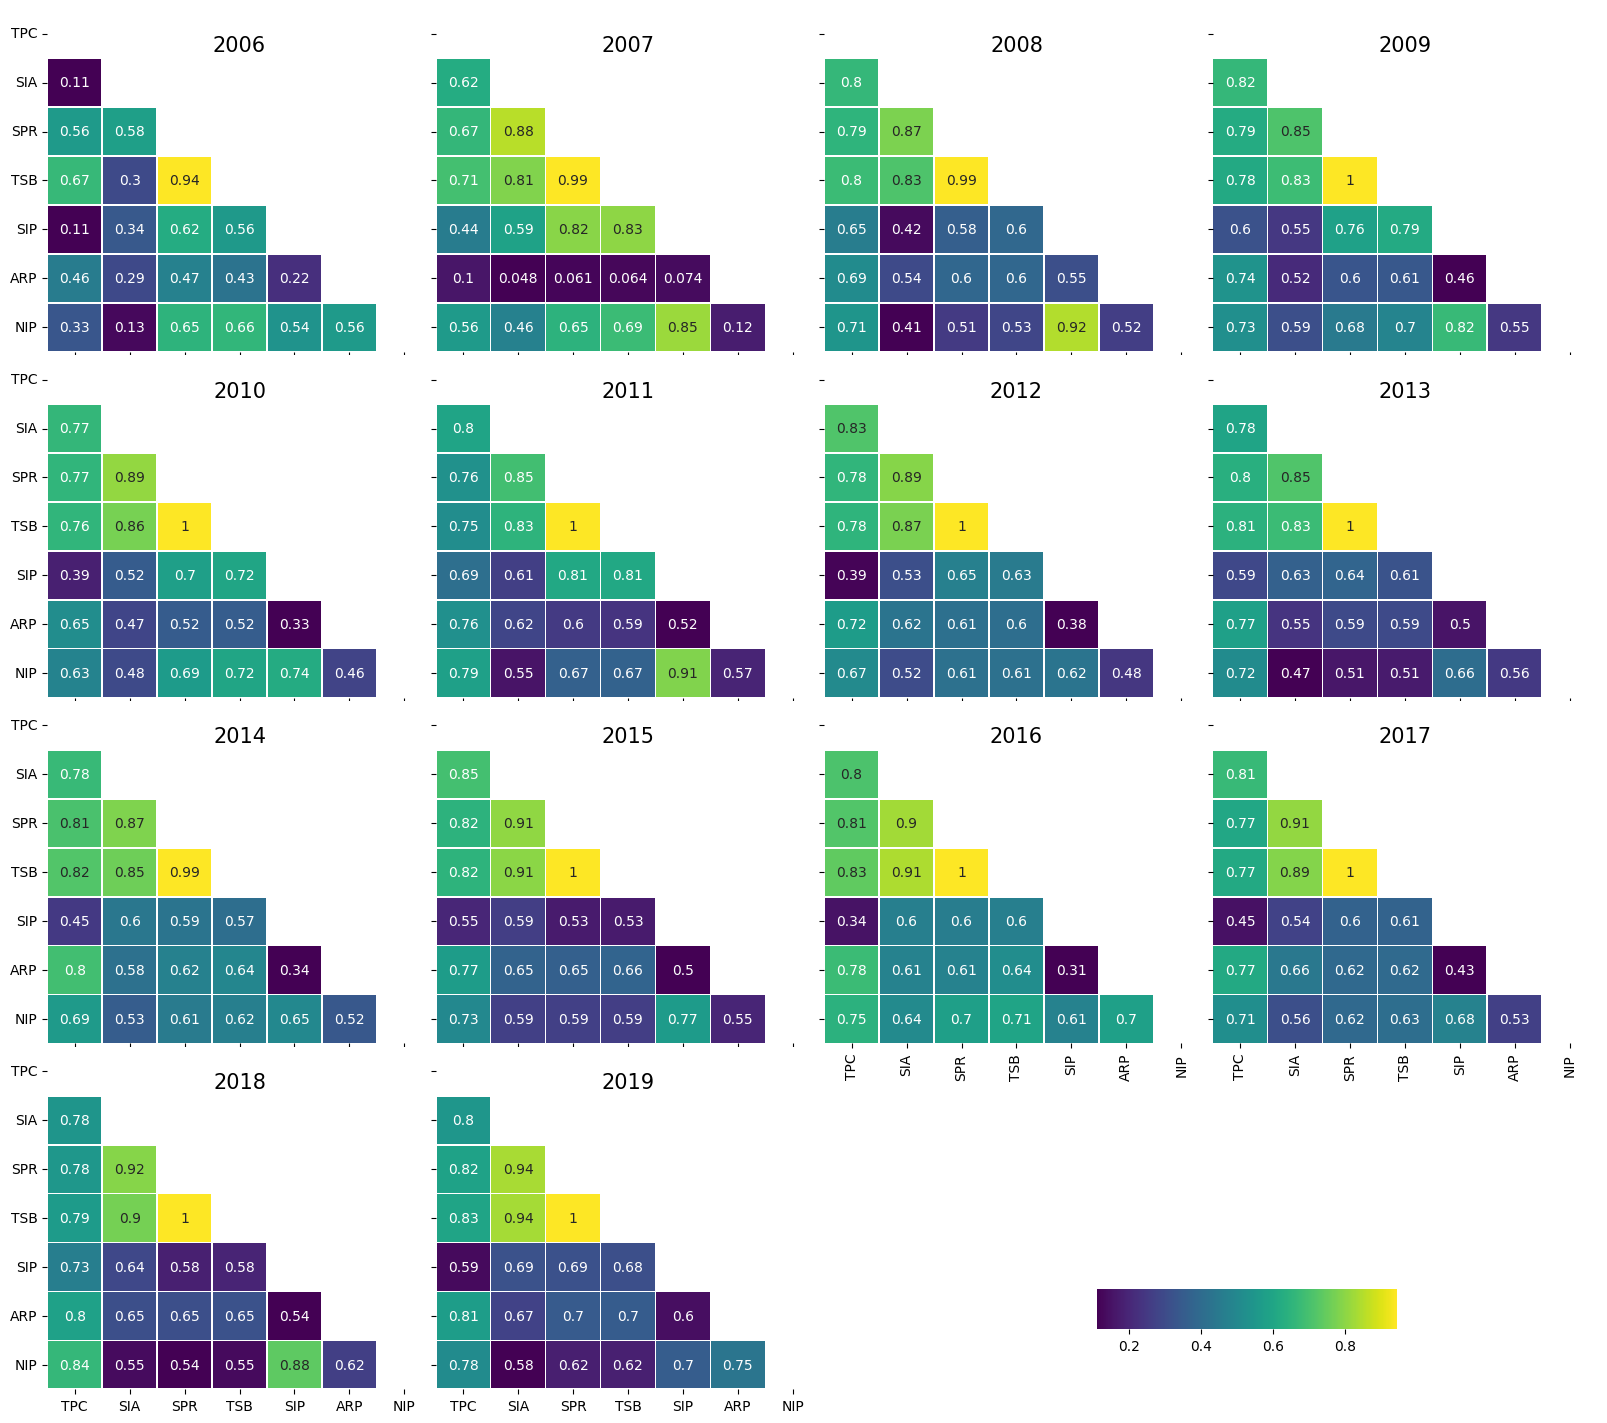

In [32]:
from matplotlib import rcParams
rcParams['xtick.minor.bottom'] = False
rcParams['axes.titlepad'] = -30  # posição do titulo "Ano"
f, axs = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(20, 20)) # 
axs = axs.flatten()
cbar_ax = f.add_axes([.65, .14, .15, .02])
for i, ano in enumerate(anos): 
    cols = dados_br[dados_br['ano']==ano][variaveis].corr().index
    cm = dados_br[dados_br['ano']==ano][cols].corr()
    mask = np.zeros_like(cm)
    mask[np.triu_indices_from(mask)] = True
    ax = axs[i]
    axs[i].set_title(ano, fontsize=15)
    sns.heatmap(cm,  
                cbar=i == 0, 
                annot=True, 
                linewidths=.5,
                cmap = 'viridis', #  'Greys'
                ax=ax, 
                cbar_ax=None if i else cbar_ax, cbar_kws={"orientation": "horizontal"}, 
                mask=mask)   # 
    ax.set_yticklabels(variaveis, rotation=0)
axs[10].xaxis.set_tick_params(labelbottom=True, rotation=90)
axs[11].xaxis.set_tick_params(labelbottom=True, rotation=90)
axs[14].set_axis_off()
axs[15].set_axis_off()
plt.subplots_adjust(top=0.8, wspace=0.01, hspace=0.01)
plt.savefig('corr_anos_bw.pdf')
plt.show();

## Padronizando os dados

Usaremos a função [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) para padronizar nossos dados para uma escala com média $0$ e variância $1$.

In [33]:
from sklearn.preprocessing import StandardScaler # para o ano de 2019
#x = StandardScaler().fit_transform(dados_19)
#x = pd.DataFrame(x, columns=dados_19.columns)   

In [34]:
dados_anos_p = []
for i, ano in enumerate(anos):
    cols = dados_br[dados_br['ano']==ano][variaveis]
    dadosp = StandardScaler().fit_transform(cols)
    dadosp = pd.DataFrame(dadosp, columns=cols.columns)
    dadosp['ano'] = ano
    dados_anos_p.append(dadosp)
dadosp = dados_anos_p[0]
for i in range(len(dados_anos_p)-1):
    dadosp = pd.concat([dadosp, dados_anos_p[i+1]], axis=0) # Concatenando os dados

## Encontrando os Componentes Principais

Calculating PCA involves following steps:

1. Calcular a matriz de covariâncias
2. Calcular os autovalores e autovetores
3. Formar os Componentes Principais
4. Projetar os componentes em um novo espaço 

Para facilitar podemos usar o pacote sklearn que possui o [PCA module](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) para obter os CP's

Na função ``PCA()``, `n_components` especifica quantos componentes serão retornados depois do ajuste e da transformação 

In [35]:
from sklearn.decomposition import PCA # para o ano de 2019
pcamodel = PCA()
#pca = pcamodel.fit_transform(x)
#pca.shape

In [36]:
cps  =['cp1', 'cp2', 'cp3', 'cp4', 'cp5', 'cp6', 'cp7']

In [37]:
pca_f = []
exp_variance = []
var_ratio = []
comp_corr = []
comp_cor = []
for i, ano in enumerate(anos):
    pca = pcamodel.fit_transform(dadosp[dadosp['ano'] == ano].drop('ano', axis=1))

    exp_variance.append(np.cumsum(np.round(pcamodel.explained_variance_ratio_, decimals=4)*100))
    var_ratio.append(pcamodel.explained_variance_ratio_)
    comp_corr.append(pcamodel.components_.T)
    comp_cor.append(pcamodel.components_)

    pca = pd.DataFrame(pca, columns=[cps])
    pca['ano'] = ano
    pca_f.append(pca)
    
pca = pca_f[0]
for i in range(len(pca_f)-1):
    pca = pd.concat((pca, pca_f[i+1]), axis=0, ignore_index=True) # Concatenando os dados
pca.columns = pca.columns.map(''.join)

In [38]:
#resultado = pd.DataFrame({'cp1':pca[:, 0], 'cp2':pca[:, 1]}, index=x.index)

In [39]:
pcamodel.explained_variance_ 

array([5.45868273e+00, 6.82360512e-01, 4.73260570e-01, 2.19799016e-01,
       9.90609806e-02, 6.75638138e-02, 5.29783037e-04])

In [40]:
pcamodel.explained_variance_ratio_

array([7.79671767e-01, 9.74625659e-02, 6.75965105e-02, 3.13942201e-02,
       1.41490271e-02, 9.65023993e-03, 7.56696984e-05])

In [41]:
# variância explicada acumulada
np.cumsum(np.round(pcamodel.explained_variance_ratio_, decimals=4)*100)

array([ 77.97,  87.72,  94.48,  97.62,  99.03, 100.  , 100.01])

In [42]:
np.round(pcamodel.explained_variance_ratio_,2)

array([0.78, 0.1 , 0.07, 0.03, 0.01, 0.01, 0.  ])

## Análise gráfica dos componentes

### Gráfico da variância acumulada

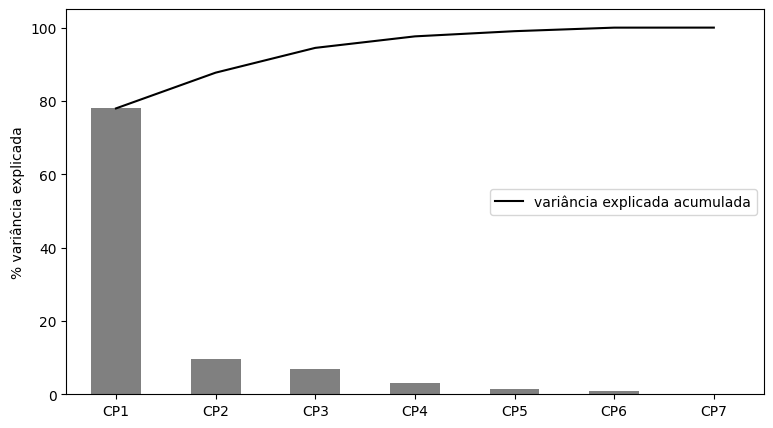

In [43]:
# variâncias acumuladas
tot = sum(pcamodel.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(pcamodel.explained_variance_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
# número de CPs gerados (k = p)
cp =['CP'+str(i+1) for i in range(len(pcamodel.components_))]
# dataframe com as variâncias acumuladas para criar o scree plot
df = pd.DataFrame({'cp': cp, 'var_exp': var_exp, 'cum_var_exp': cum_var_exp})
# scree plot com %
fig, ax = plt.subplots(figsize=(9,5))
df.plot.bar('cp', 'var_exp', color='gray', ax=ax, legend=False)
df.plot.line('cp', 'cum_var_exp', color='black', ax=ax)
plt.legend(labels=['variância explicada acumulada'],
           loc='center right',)
plt.ylabel('% variância explicada')
plt.xlabel('');

### Distribuição do primeiro componente

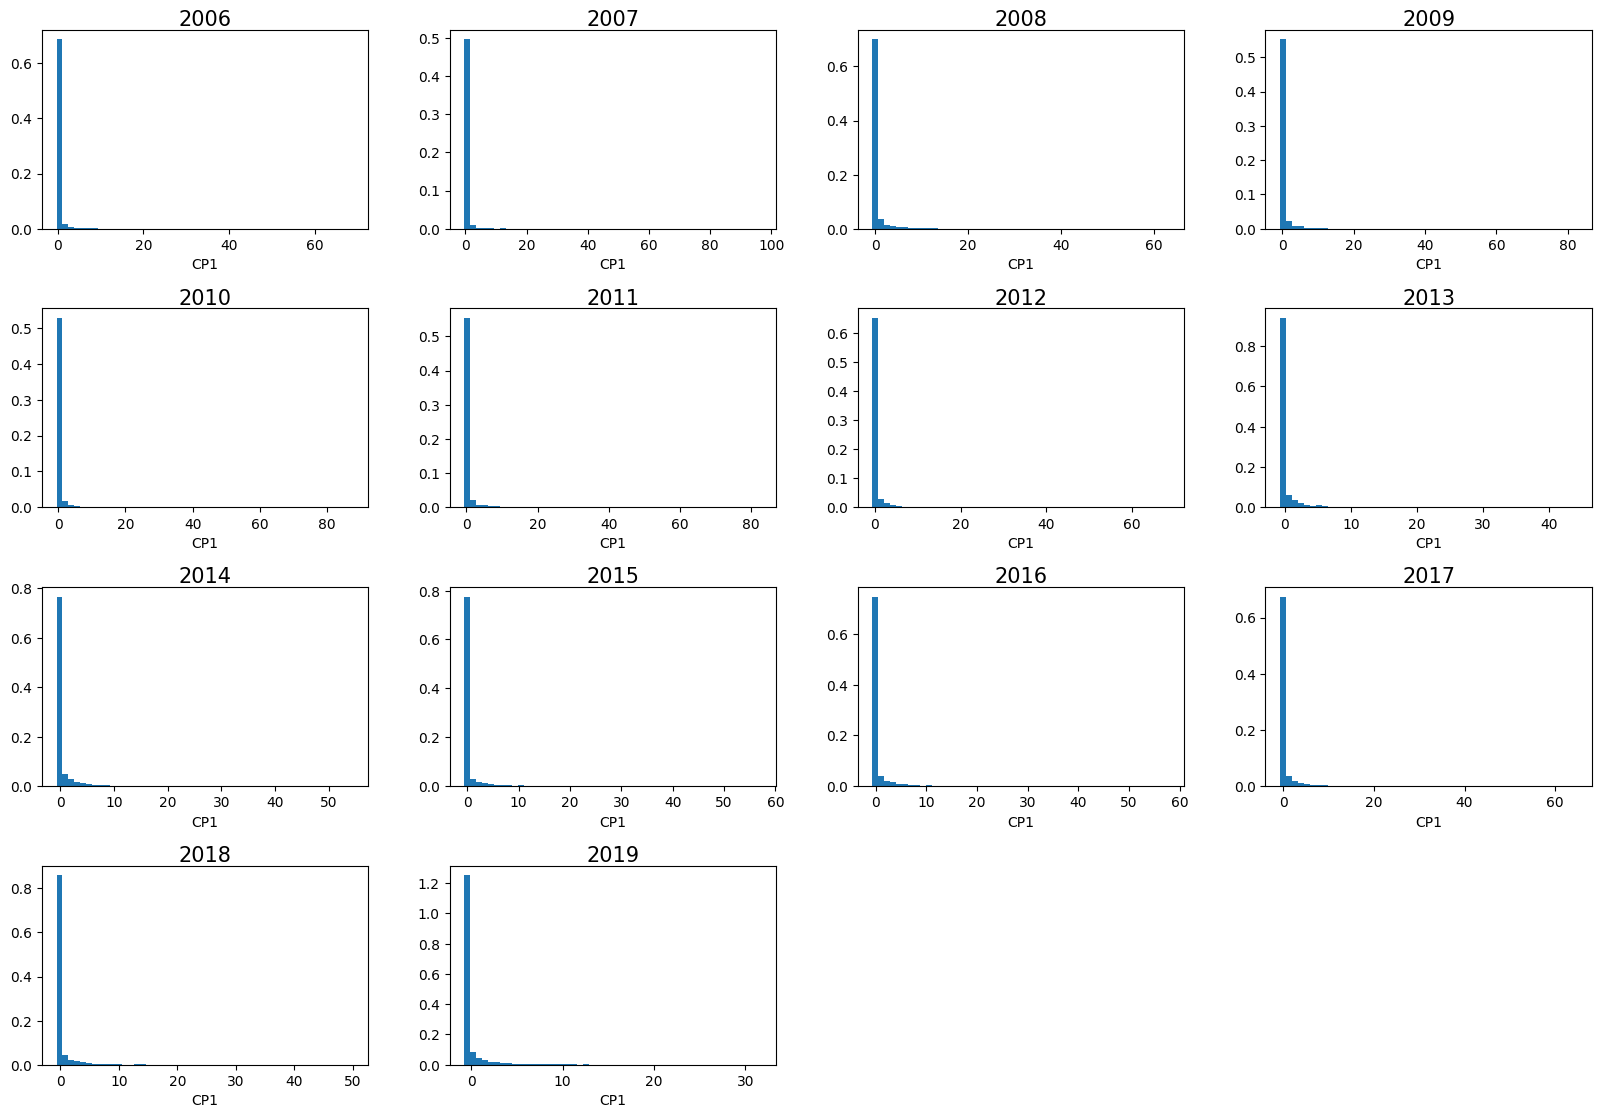

In [44]:
from matplotlib import rcParams
rcParams['axes.titlepad'] = 3  # posição do titulo "Ano"
f, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 15)) # 
axs = axs.flatten()
for i, ano in enumerate(anos): 
    pca_ano = pca[pca['ano'] == ano]
    axs[i].hist(pca_ano.iloc[:,0], density=True, bins=50)
    ax = axs[i]
    ax.set_title(ano, fontsize=15)
    ax.set_xlabel('CP1')
axs[14].set_axis_off()
axs[15].set_axis_off()
plt.subplots_adjust(top=0.8, wspace=0.25, hspace=0.4)
plt.show();

### Gráfico da razão da variância explicada

In [45]:
var_ratio_df = pd.DataFrame(var_ratio, index=anos, columns=cps).T

In [46]:
var_ratio_df

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
cp1,0.552965,0.651352,0.715422,0.749126,0.707580,0.764312,0.714124,0.717999,0.718590,0.743343,0.741425,0.728550,0.756377,0.779672
cp2,0.154197,0.143339,0.149718,0.097440,0.122167,0.094537,0.111441,0.111964,0.112639,0.118816,0.117127,0.106953,0.131337,0.097463
cp3,0.123329,0.104308,0.072058,0.081465,0.091662,0.085571,0.081484,0.080269,0.083907,0.068883,0.078496,0.082663,0.067409,0.067597
cp4,0.102931,0.070318,0.037711,0.044345,0.047529,0.036261,0.058184,0.047449,0.045160,0.039759,0.033179,0.048305,0.024322,0.031394
cp5,0.043655,0.023196,0.018114,0.014408,0.018796,0.014952,0.022815,0.030152,0.026897,0.020310,0.018870,0.021130,0.015350,0.014149
cp6,0.022623,0.007257,0.006438,0.012908,0.011920,0.004064,0.011691,0.011798,0.012192,0.008645,0.010611,0.012296,0.005133,0.009650
cp7,0.000299,0.000230,0.000539,0.000307,0.000345,0.000304,0.000263,0.000371,0.000615,0.000244,0.000292,0.000102,0.000072,0.000076


In [47]:
round(var_ratio_df.loc['cp1'].max()*100,2)

77.97

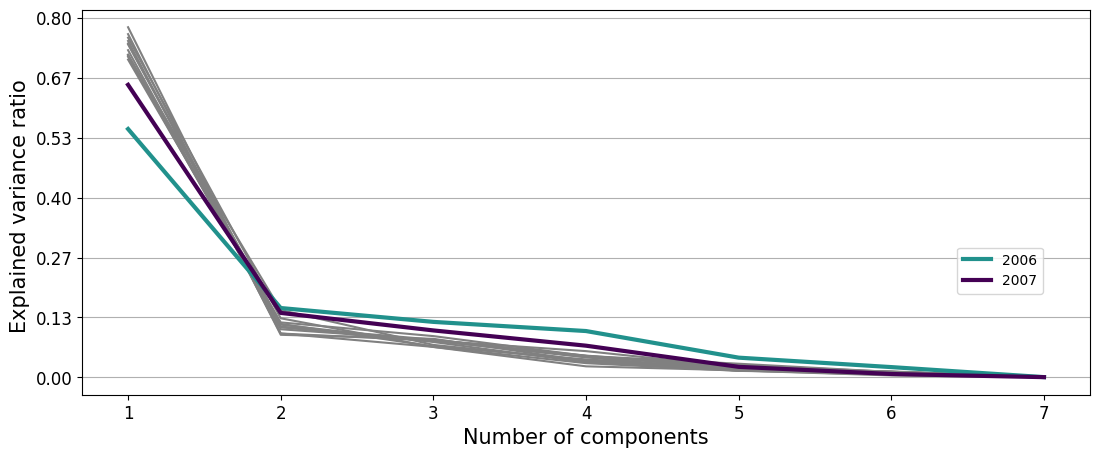

In [49]:
f, ax = plt.subplots(figsize=(13,5)) # 
plt.plot(cps, var_ratio_df,  markersize=7, color='grey') 
plt.plot(cps, var_ratio_df.iloc[:,0],  markersize=7, color='#21918c', linewidth=3, label='2006') 
plt.plot(cps, var_ratio_df.iloc[:,1],  markersize=7, color='#440154', linewidth=3, label='2007') 

#plt.xlabel('Número de componentes', fontsize = 15)
#plt.ylabel('Variância explicada acumulada', fontsize = 15)

plt.xlabel('Number of components', fontsize = 15)
plt.ylabel('Explained variance ratio ', fontsize = 15)

xvals = np.linspace(1,7, 7)
ax.set_xticks(np.arange(len(range(0,7))))
ax.set_xticklabels(xvals, fontsize = 12)
ax.set_xticklabels(["{:,.0f}".format(x) for x in xvals], fontsize=12)

yvals = np.linspace(0,0.8, 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.2f}".format(y) for y in yvals], fontsize=12)
ax.yaxis.grid()

ax.legend()
plt.legend(bbox_to_anchor=(0.96, 0.4))

In [ ]:
f, ax = plt.subplots(figsize=(13,5)) # 
plt.plot(var_ratio_df, linewidth=2.5)
plt.xlabel('Número de componentes', fontsize = 15)
plt.ylabel('Variância explicada acumulada', fontsize = 15)

xvals = np.linspace(1,7, 7)
ax.set_xticks(np.arange(len(range(0,7))))
ax.set_xticklabels(xvals, fontsize = 12)
ax.set_xticklabels(["{:,.0f}".format(x) for x in xvals], fontsize=12)

yvals = np.linspace(0,0.8, 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.2f}".format(y) for y in yvals], fontsize=12)
ax.yaxis.grid()

label_06 = "2006"

plt.annotate(label_06, # this is the text
             (0,0.5530), # these are the coordinates to position the label
             textcoords="offset points", # how to position the text
             xytext=(0,-15), # distance from text to points (x,y)
             ha='center', # horizontal alignment can be left, right or center
             bbox=dict(boxstyle="square,pad=0.2", fc="white", ec="gray", lw=1))
label_07 = "2007"

plt.annotate(label_07, # this is the text
             (0,0.6514), # these are the coordinates to position the label
             textcoords="offset points", # how to position the text
             xytext=(0,-20), # distance from text to points (x,y)
             ha='center', # horizontal alignment can be left, right or center
             bbox=dict(boxstyle="square,pad=0.2", fc="white", ec="gray", lw=1)) 
plt.show();

### *Scree plot*

O *Scree plot* é um gráfico com os autovalores de cada componente

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(pcamodel.explained_variance_)
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada acumulada')
plt.grid()
plt.show()

É possível ver pelo gráfico que o primeiro componente já explica $83,08\%$ da variância dos dados.

### Diagrama de dispersão entre PC1 e PC2

`Usando scikit-learn` contém todos os componentes. Nesse gráfico vamos visualizar a relação entre os dois primeiros 

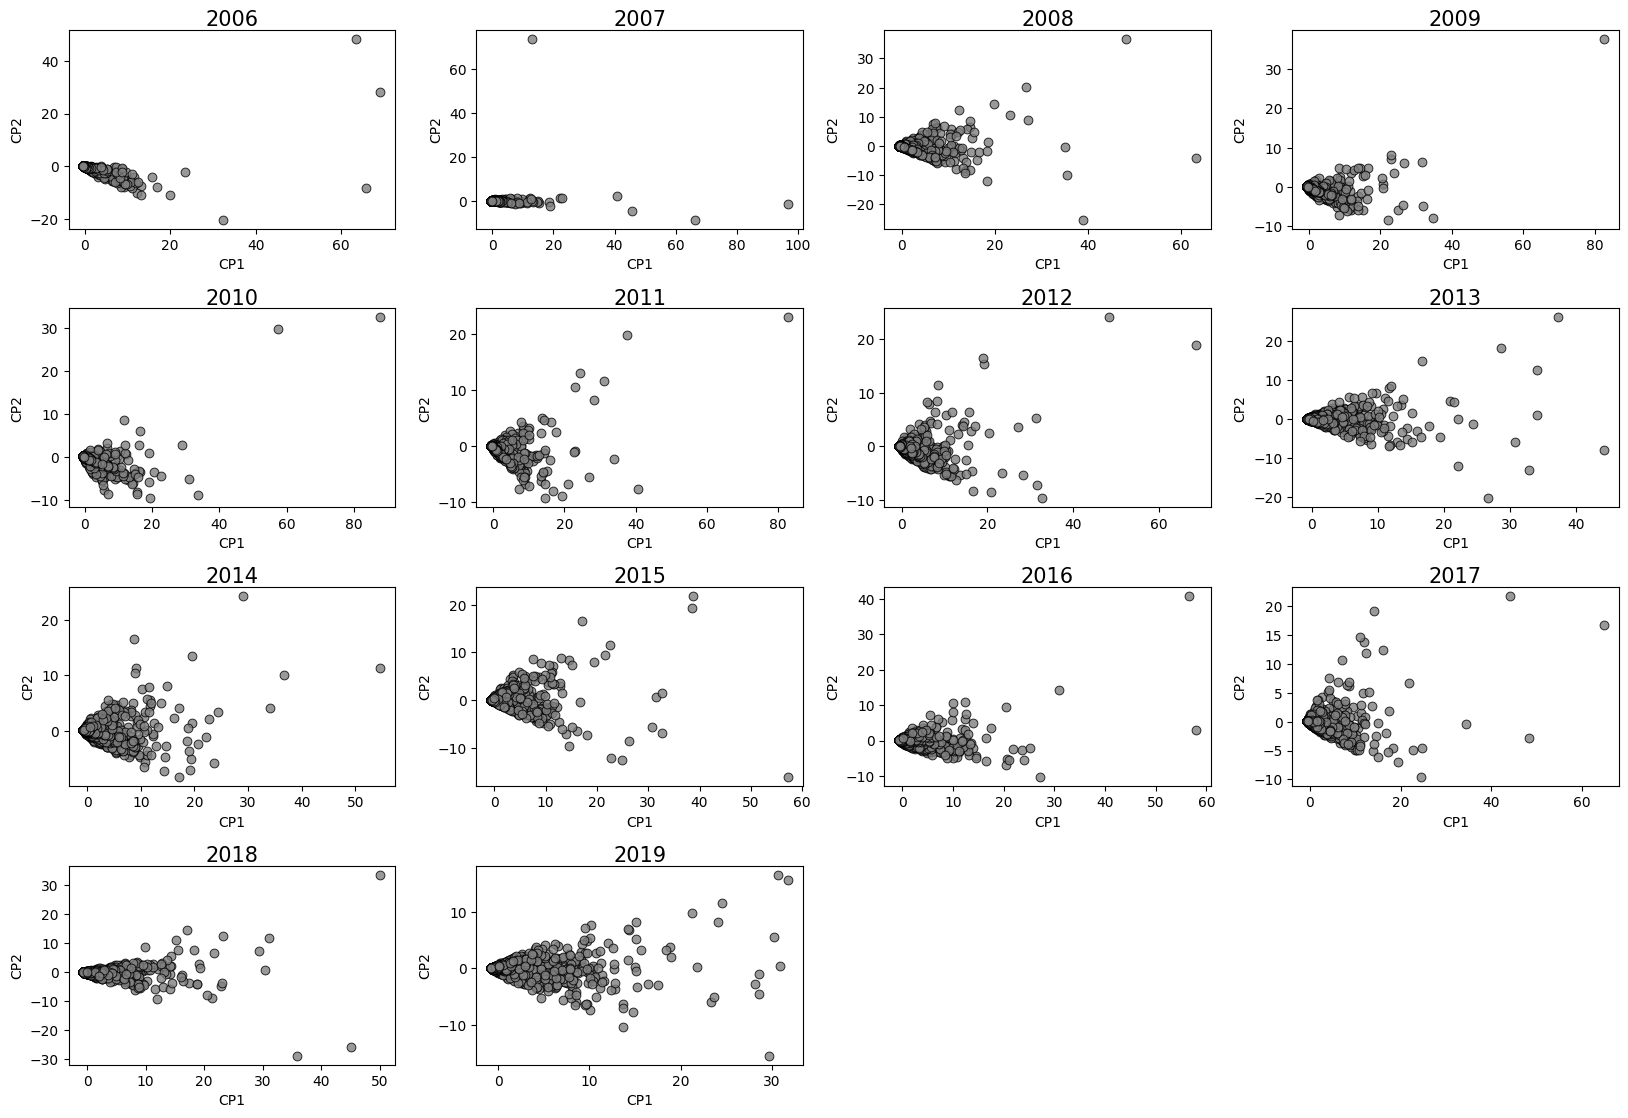

In [51]:
from matplotlib import rcParams
rcParams['axes.titlepad'] = 3  # posição do titulo "Ano"
f, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 15)) # 
axs = axs.flatten()
for i, ano in enumerate(anos): 
    pca_ano = pca[pca['ano'] == ano]
    axs[i].scatter(pca_ano.cp1, pca_ano.cp2, edgecolors='black', alpha=0.8, linewidths=.7, s=40, c='gray');
    #axs[i].grid()
    ax = axs[i]
    ax.set_title(ano, fontsize=15)
    ax.set_xlabel('CP1')
    ax.set_ylabel('CP2')
#plt.xlabel('CP1')
#plt.ylabel('CP2')

axs[14].set_axis_off()
axs[15].set_axis_off()
plt.subplots_adjust(top=0.8, wspace=0.25, hspace=0.4)
plt.show();

### Efeito das variaveis em cada componente

O atributo `components_` nos dá os autovetores, que representam a direção de máxima variância dos dados. Ao verificar a correlação dos componentes com as variáveis originais podemos ver a influencia que cada variável tem sobre os componentes.

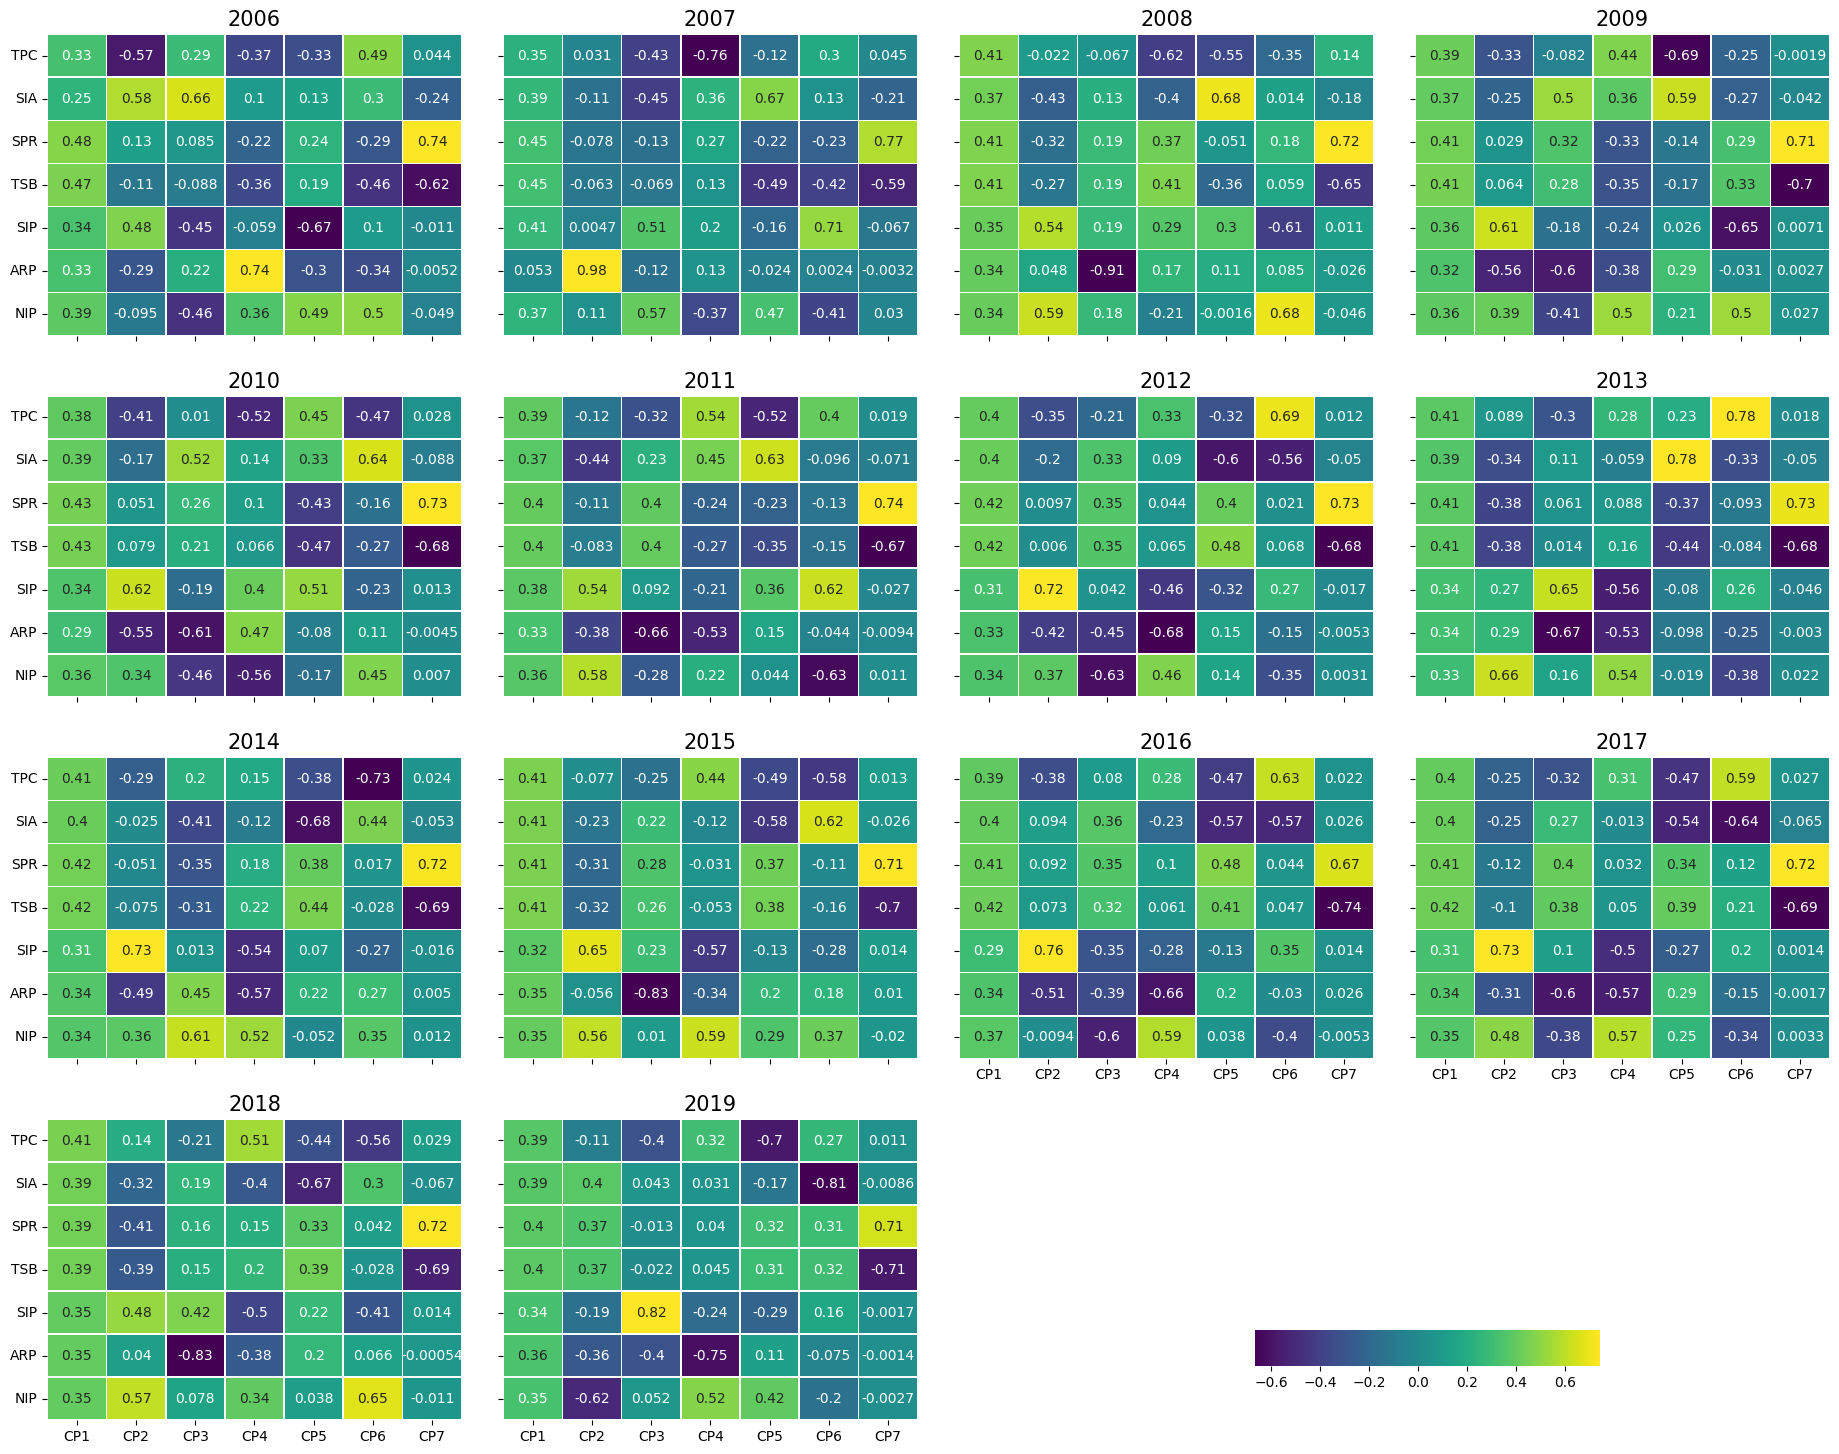

In [52]:
rcParams['axes.titlepad'] = 6  # posição do titulo "Ano"
f, axs = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(23, 18)) # 
axs = axs.flatten()
cbar_ax = f.add_axes([.65, .14, .15, .02])
for i, ano in enumerate(anos): 
    mask = np.zeros_like(cm)
    mask[np.triu_indices_from(mask)] = True
    ax = axs[i]
    ax.set_title(ano, fontsize=15)
    sns.heatmap(comp_corr[i],  
                cbar=i == 0, 
                annot=True, 
                linewidths=.5,
                cmap = 'viridis', 
                ax=ax,
                cbar_ax=None if i else cbar_ax, cbar_kws={"orientation": "horizontal"}, 
                xticklabels=[ "CP"+str(X) for X in range(1,pcamodel.n_components_+1)])
    ax.set_yticklabels(variaveis, rotation=0)
axs[10].xaxis.set_tick_params(labelbottom=True)
axs[11].xaxis.set_tick_params(labelbottom=True)
axs[14].set_axis_off()
axs[15].set_axis_off()
plt.subplots_adjust(wspace=0.1)
plt.savefig('corr_pca_var.pdf')
plt.show();

### ACP *Biplot*

Biplot é um gráfico interessante e contém muitas informações úteis.

Ele contém dois gráficos:

1. * Gráfico de dispersão do ACP * que mostra os dois primeiros componentes (já traçamos isso acima)
2. * Gráfico de autovetores do ACP * que mostra a intensidade com que cada característica influencia um componente principal.

**PCA Loading Plot:** Todos os vetores começam na origem e seus valores projetados nos componentes explicam quanto peso eles têm naquele componente. Além disso, os ângulos entre vetores individuais informam sobre a correlação entre eles.

Mais sobre o biplot [aqui] (http://www.nonlinear.com/support/progenesis/comet/faq/v2.0/pca.aspx)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
myplot(pca[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(x.columns))
plt.show()

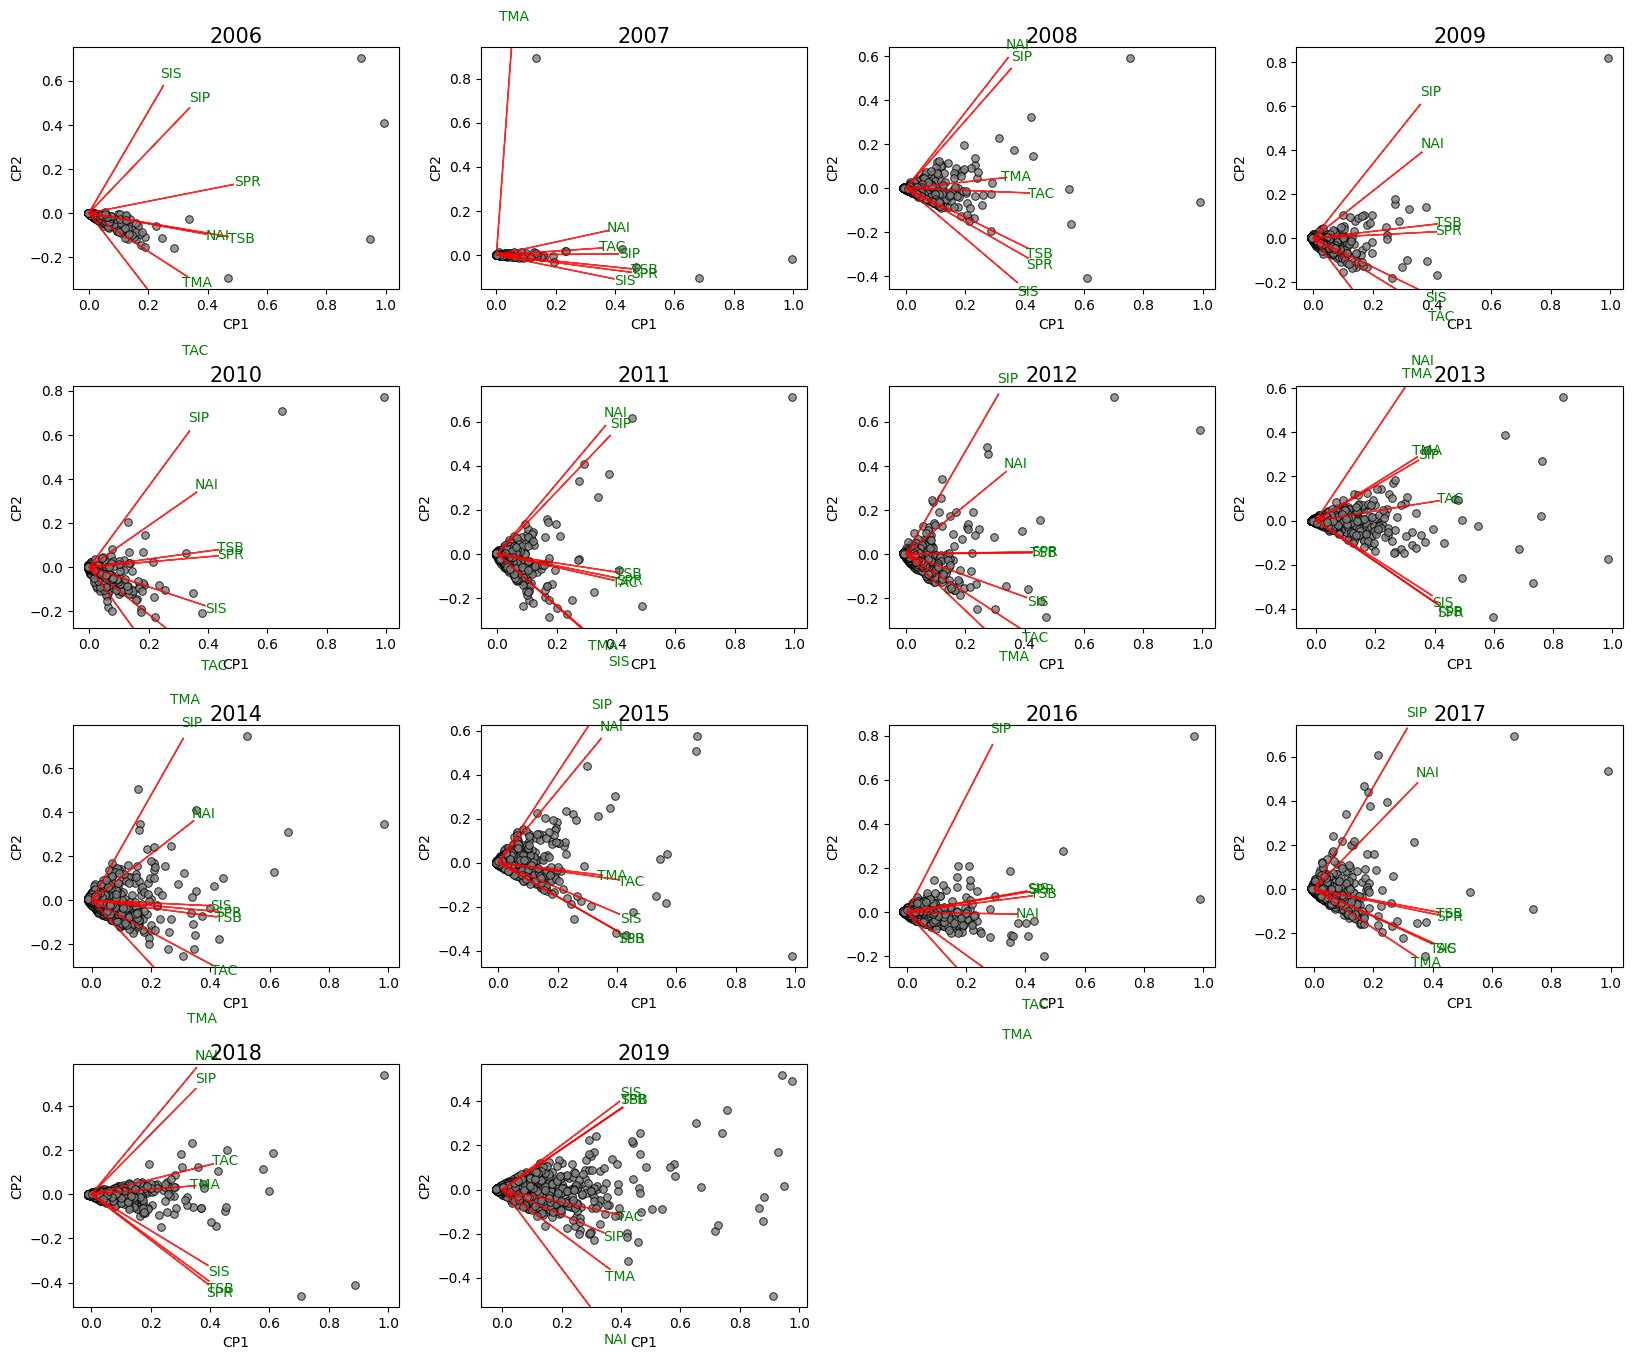

In [ ]:
from matplotlib import rcParams
rcParams['axes.titlepad'] = 3  # posição do titulo "Ano"
f, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 15)) # 
axs = axs.flatten()

for i, ano in enumerate(anos):
    ax = axs[i]
    ax.set_title(ano, fontsize=15)
    score = pca[pca['ano']==ano].iloc[:,0:2].values
    coeff = comp_cor[i][0:2].T
    labels = list(dados_19.columns)
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    axs[i].scatter(xs * scalex, ys * scaley, edgecolors='black', alpha=0.8, linewidths=.7, s=30, c='gray')
    for j in range(n):
        axs[i].arrow(0, 0, coeff[j,0], coeff[j,1],color = 'r',alpha = 0.8)
        if labels is None:
            axs[i].text(coeff[j,0]* 1.1, coeff[j,1] * 1.1, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            axs[i].text(coeff[j,0]* 1.1, coeff[j,1] * 1.1, labels[j], color = 'g', ha = 'center', va = 'center')
    ax.set_xlabel('CP1')
    ax.set_ylabel('CP2')
    #ax.set(xlim=(None, 0.75), ylim=(None, 0.7))

axs[14].set_axis_off()
axs[15].set_axis_off()
plt.subplots_adjust(top=0.95, wspace=0.25, hspace=0.4)
plt.show();

## Análise Espacial com CP

In [53]:
dados_geo = dados_br[dados_br['ano']==2019][geometry]
dados_geo.reset_index(inplace=True)
dados_geo.drop('index', axis=1, inplace=True)
dados_geo.set_index(dados_geo.index, inplace=True)
dados_geo.reset_index(level=0, inplace=True)
#dados_geo

In [54]:
pca_final = []
for ano in anos:
    pca_anos = pca[pca['ano']==ano]
    pca_anos.reset_index(inplace=True)
    pca_anos = pca_anos.drop('index', axis=1)
    pca_anos.set_index(pca_anos.index, inplace=True)
    pca_anos.reset_index(level=0, inplace=True)
    pca_anos = pca_anos.merge(dados_geo)
    pca_final.append(pca_anos)

In [55]:
resumo_cp = pca_final[0].cp1.describe().values[1:]
for i in range(len(anos)-1):
    #resumo_cp = pd.concat((resumo_cp, pca_final[i+1].cp1.describe().values[1:]), axis=0, ignore_index=True)

SyntaxError: ignored

In [56]:
pca_final[13].cp1.describe()

count    5.568000e+03
mean    -1.633432e-16
std      2.336382e+00
min     -7.459034e-01
25%     -7.459034e-01
50%     -7.459034e-01
75%     -4.313808e-01
max      3.173307e+01
Name: cp1, dtype: float64

In [57]:
pca_y = pca_final[0]
for i in range(len(pca_final)-1):
    pca_y = pd.concat((pca_y, pca_final[i+1]), axis=0, ignore_index=True) # Concatenando os dados

In [58]:
pca_y.drop('index', axis=1, inplace=True)

In [59]:
dados_cp = geopandas.GeoDataFrame(pca_y)
dados_cp

,cp1,cp2,cp3,cp4,cp5,cp6,cp7,ano,mun,geometry
0,-0.292403,0.142362,-0.070236,-0.014073,0.046153,0.020671,0.001816,2006,1100015,"POLYGON ((-62.19465 -11.82746, -62.17332 -11.8..."
1,-0.292403,0.142362,-0.070236,-0.014073,0.046153,0.020671,0.001816,2006,1100023,"POLYGON ((-62.53648 -9.73222, -62.49559 -9.772..."
2,-0.292403,0.142362,-0.070236,-0.014073,0.046153,0.020671,0.001816,2006,1100031,"POLYGON ((-60.37075 -13.36363, -60.37959 -13.3..."
3,-0.292403,0.142362,-0.070236,-0.014073,0.046153,0.020671,0.001816,2006,1100049,"POLYGON ((-61.00080 -11.29737, -61.00302 -11.4..."
4,-0.292403,0.142362,-0.070236,-0.014073,0.046153,0.020671,0.001816,2006,1100056,"POLYGON ((-61.49976 -13.00525, -61.43437 -13.0..."
...,...,...,...,...,...,...,...,...,...,...
77947,0.105004,0.290621,-0.271466,-0.123972,-0.065284,-0.145983,-0.002464,2019,5222005,"POLYGON ((-48.38114 -16.63141, -48.37211 -16.6..."
77948,1.284144,0.912519,-0.443650,0.142041,-0.229729,-0.412661,-0.046065,2019,5222054,"POLYGON ((-49.84456 -17.58262, -49.83248 -17.5..."
77949,-0.745903,0.031665,0.076779,0.109366,0.006802,0.035405,0.000500,2019,5222203,"POLYGON ((-47.11416 -14.67412, -47.10148 -14.6..."
77950,0.051077,0.435629,-0.136473,-0.051814,0.033754,-0.256250,-0.019277,2019,5222302,"POLYGON ((-48.75586 -14.86267, -48.73669 -14.8..."


In [60]:
#resultado.reset_index(inplace=True)
#dados_19_geo.set_index(resultado.index, inplace=True)
#dados_19_geo.reset_index(level=0, inplace=True)
#dados_cp = resultado.merge(dados_19_geo)
#dados_cp = geopandas.GeoDataFrame(dados_cp) # problema: perdendo dados de dois "municípios"

### Mapas Temáticos - CP1

In [61]:
referencia = jenkspy.jenks_breaks( dados_cp[dados_cp['ano']==2019]['cp1'][dados_cp[dados_cp['ano']==2019]['cp1'] != 0], nb_class=4)   #Fisher Jenks a partir dos dados de 2019
#referencia[0] = 0 
referencia[4] =  dados_cp['cp1'].max()

In [62]:
len(referencia), referencia

(5,
 [-0.7459034431294619,
  1.0440075595424938,
  5.706391546419698,
  16.39726120167273,
  96.69198538996596])

In [63]:
labels = [str(round(referencia[0])) + ' - 0',
          '0 - '+ str(round(referencia[1])),
          str(round(referencia[1])) + ' - '+ str(round(referencia[2])),
          str(round(referencia[2])) + ' - '+ str(round(referencia[3])), 
          str(round(referencia[3])) + ' - '+ str(round(referencia[4]))]     #rótulos da legenda
len(labels), labels

(5, ['-1 - 0', '0 - 1', '1 - 6', '6 - 16', '16 - 97'])

In [64]:
classif = mc.UserDefined(dados_cp['cp1'].values,referencia)
len(classif.counts), classif

(5, UserDefined           
 
    Interval      Count
 ----------------------
 [-0.75, -0.75] |     1
 (-0.75,  1.04] | 71144
 ( 1.04,  5.71] |  5203
 ( 5.71, 16.40] |  1403
 (16.40, 96.69] |   201)

In [65]:
cl = [labels[i] for i in classif.yb]
dados_cp = dados_cp.assign(cl = cl)
dados_cp.cl = pd.Categorical(dados_cp.cl,ordered=True,categories=labels)

In [ ]:
color_list = ["lightgrey", "darkgrey", "gray", "dimgrey", "black"]
colors_map = colors.LinearSegmentedColormap.from_list("", color_list)

In [ ]:
f, axs = plt.subplots(nrows=4, ncols=4, figsize=(30, 30)) # 
axs = axs.flatten()
for i, ano in enumerate(anos):
    ax = axs[i]
    dados_cp[dados_cp['ano']==ano].plot(column='cl', ax=ax, legend=False, categorical=True, cmap=colors_map); # plot
    ax.set_axis_off()
    ax.set_title(ano, fontsize=30)
    ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))   # adiciona a divisão estadual
lines = [Line2D([0], [0], color=c, marker='o', markersize=30, linestyle='') for c in color_list] # linewidth=20, linestyle='dotted'
axs[13].legend(lines, labels, loc='botton left', bbox_to_anchor=(1.85, 0.75), frameon=False, prop={'size': 30})
axs[14].set_axis_off()
axs[15].set_axis_off()
axs[15].imshow(img)
plt.subplots_adjust(left=7, bottom=7, right=8, top=8, wspace=0.001, hspace=0.005)
plt.show();

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#color_list = ["#fde725", "#5ec962", "#21918c", "#3b528b", "#440154"]
color_list = ["#440154", "#3b528b", "#21918c", "#5ec962", "#fde725"] 
#color_list = ["#440154", "#fde725", "#5ec962", "#21918c", "#3b528b"] 

colors_map_v = colors.LinearSegmentedColormap.from_list("", color_list)

In [ ]:
f, axs = plt.subplots(nrows=4, ncols=4, figsize=(30, 30)) # 
axs = axs.flatten()
for i, ano in enumerate(anos):
    ax = axs[i]
    dados_cp[dados_cp['ano']==ano].plot(column='cl', ax=ax, legend=False, categorical=True, cmap=colors_map_v); # plot
    ax.set_axis_off()
    ax.set_title(ano, fontsize=30)
    ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))   # adiciona a divisão estadual
lines = [Line2D([0], [0], color=c, marker='o', markersize=30, linestyle='') for c in color_list] # linewidth=20, linestyle='dotted'
axs[13].legend(lines, labels, loc='botton left', bbox_to_anchor=(1.85, 0.75), frameon=False, prop={'size': 30})
axs[14].set_axis_off()
axs[15].set_axis_off()
axs[15].imshow(img)
plt.subplots_adjust(left=7, bottom=7, right=8, top=8, wspace=0.001, hspace=0.005)
plt.show();

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
f, axs = plt.subplots(nrows=4, ncols=4, figsize=(30, 30)) # 
axs = axs.flatten()
for i, ano in enumerate(anos):
    ax = axs[i]
    dados_cp[dados_cp['ano']==ano].plot(column='cp1',  ax=ax, legend=False, k=5, linewidth=0, scheme='quantiles', cmap=colors_map); 
    ax.set_axis_off()
    ax.set_title(ano, fontsize=30)
    ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))   # adiciona a divisão estadual
lines = [Line2D([0], [0], color=c, marker='o', markersize=30, linestyle='') for c in color_list] # linewidth=20, linestyle='dotted'
#axs[13].legend(lines, labels, loc='botton left', bbox_to_anchor=(1.85, 0.75), frameon=False, prop={'size': 30})
axs[14].set_axis_off()
axs[15].set_axis_off()
axs[15].imshow(img)
plt.subplots_adjust(left=7, bottom=7, right=8, top=8, wspace=0.001, hspace=0.005)
plt.show();

In [ ]:
f, axs = plt.subplots(nrows=4, ncols=4, figsize=(30, 30)) # 
axs = axs.flatten()
for i, ano in enumerate(anos):
    ax = axs[i]
    dados_cp[dados_cp['ano']==ano].plot(column='cp1',  ax=ax, legend=False, k=5, linewidth=0, scheme='equal_interval', cmap=colors_map); 
    ax.set_axis_off()
    ax.set_title(ano, fontsize=30)
    ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))   # adiciona a divisão estadual
lines = [Line2D([0], [0], color=c, marker='o', markersize=30, linestyle='') for c in color_list] # linewidth=20, linestyle='dotted'
#axs[13].legend(lines, labels, loc='botton left', bbox_to_anchor=(1.85, 0.75), frameon=False, prop={'size': 30})
axs[14].set_axis_off()
axs[15].set_axis_off()
axs[15].imshow(img)
plt.subplots_adjust(left=7, bottom=7, right=8, top=8, wspace=0.001, hspace=0.005)
plt.show();

In [ ]:
f, axs = plt.subplots(nrows=4, ncols=4, figsize=(30, 30)) # 
axs = axs.flatten()
for i, ano in enumerate(anos):
    ax = axs[i]
    dados_cp[dados_cp['ano']==ano].plot(column='cp1',  ax=ax, legend=False, k=5, linewidth=0, scheme='natural_breaks', cmap=colors_map); 
    ax.set_axis_off()
    ax.set_title(ano, fontsize=30)
    ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))   # adiciona a divisão estadual
lines = [Line2D([0], [0], color=c, marker='o', markersize=30, linestyle='') for c in color_list] # linewidth=20, linestyle='dotted'
#axs[13].legend(lines, labels, loc='botton left', bbox_to_anchor=(1.85, 0.75), frameon=False, prop={'size': 30})
axs[14].set_axis_off()
axs[15].set_axis_off()
axs[15].imshow(img)
plt.subplots_adjust(left=7, bottom=7, right=8, top=8, wspace=0.001, hspace=0.005)
plt.show();

In [ ]:
def max_p(values, k):
    """
    Given a list of values and `k` bins,
    returns a list of their Maximum P bin number.
    """
    from mapclassify import MaxP
    binning = MaxP(values, k=k)
    return binning.yb


In [ ]:
dados_cp[dados_cp['ano']==2019]['cp1'].values

array([-0.74590344, -0.74590344, -0.74590344, ..., -0.74590344,
        0.0510775 ,  1.68115842])

In [ ]:
#dados_cp_19 = dados_cp[dados_cp['ano']==2019]
max_p(dados_cp[dados_cp['ano']==2019]['cp1'].values, k=2)
#dados_cp_19.head()


In [ ]:
f, axs = plt.subplots(nrows=4, ncols=4, figsize=(30, 30)) # 
axs = axs.flatten()
for i, ano in enumerate(anos):
    ax = axs[i]
    dados_cp[dados_cp['ano']==ano].plot(column='cp1',  ax=ax, legend=False, k=5, linewidth=0, scheme='natural_breaks', cmap=colors_map); 
    ax.set_axis_off()
    ax.set_title(ano, fontsize=30)
    ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))   # adiciona a divisão estadual
lines = [Line2D([0], [0], color=c, marker='o', markersize=30, linestyle='') for c in color_list] # linewidth=20, linestyle='dotted'
#axs[13].legend(lines, labels, loc='botton left', bbox_to_anchor=(1.85, 0.75), frameon=False, prop={'size': 30})
axs[14].set_axis_off()
axs[15].set_axis_off()
axs[15].imshow(img)
plt.subplots_adjust(left=7, bottom=7, right=8, top=8, wspace=0.001, hspace=0.005)
plt.show();

### Tabela I de Moran

In [66]:
# demora um pouco
y = dados_cp[dados_cp['ano']==2019]['cp1'].values
w = Queen.from_dataframe(dados_cp[dados_cp['ano']==2019])
w.transform = 'r'

In [67]:
mi_results = []
table_I = pd.DataFrame(dados_br.ano.unique(), columns=['anos'])

In [68]:
mi_results = [Moran(dados_cp[dados_cp['ano']==ano]['cp1'].values, w) for ano in anos]
res = np.array([(mi.I, mi.EI, mi.seI_norm, mi.sim[974]) for mi in mi_results])

In [69]:
for cp in cps:
    mi_results = [Moran(dados_cp[dados_cp['ano']==ano][cp].values, w) for ano in anos]
    table_p = pd.DataFrame([(round(res.I, 3)) for ano, res in zip(anos, mi_results)], columns=[cp])
    table_I = pd.concat([table_I.reset_index(drop=True), table_p], axis=1)
#table_I.to_latex()
table_I

,anos,cp1,cp2,cp3,cp4,cp5,cp6,cp7
0,2006,0.231,0.249,0.104,0.221,0.151,0.156,0.111
1,2007,0.216,0.014,0.269,0.273,0.240,0.167,0.224
2,2008,0.436,0.372,0.367,0.293,0.107,0.171,0.255
3,2009,0.426,0.306,0.414,0.360,0.275,0.184,0.238
4,2010,0.354,0.336,0.312,0.186,0.214,0.268,0.128
5,2011,0.451,0.327,0.403,0.348,0.235,0.191,0.124
6,2012,0.478,0.357,0.397,0.393,0.242,0.228,0.178
7,2013,0.515,0.464,0.410,0.338,0.274,0.221,0.250
8,2014,0.519,0.454,0.409,0.330,0.304,0.202,0.328
9,2015,0.560,0.419,0.474,0.425,0.277,0.274,0.334


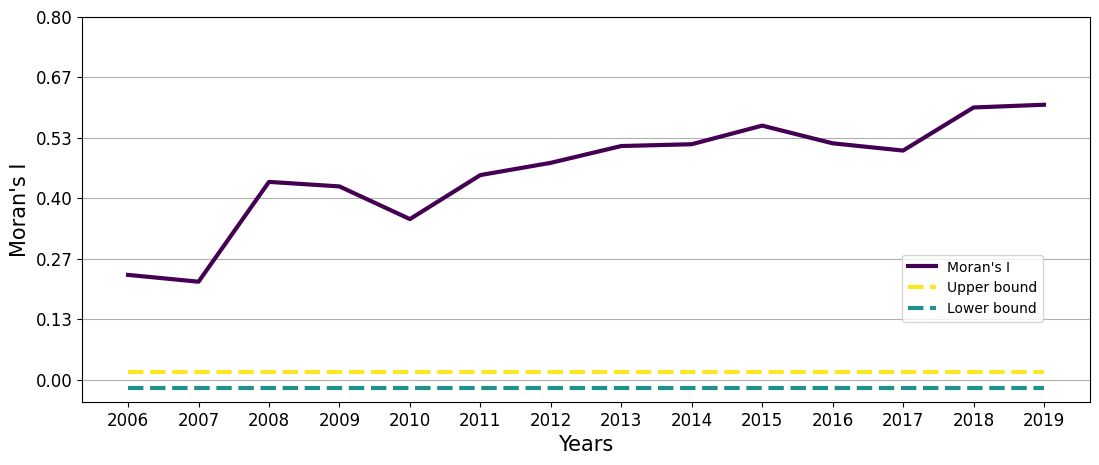

In [71]:
f, ax = plt.subplots(figsize=(13,5)) # 
plt.plot(np.arange(len(table_I['anos'])), table_I.cp1, markersize=7, color='#440154', linewidth=3, label="Moran's I") # label='CP1', label='I de Moran
ax.plot(np.arange(len(table_I['anos'])), res[:,1]+1.96*res[:,2], color='#fde725', linewidth=3, label='Upper bound',linestyle='dashed') # label='Limite superior '
ax.plot(np.arange(len(table_I['anos'])), res[:,1]-1.96*res[:,2], color='#21918c', linewidth=3, label='Lower bound',linestyle='dashed') # 
ax.set_xticks(np.arange(len(table_I['anos'])))
ax.set_xticklabels(anos, fontsize = 12)

#ax.set_ylabel('I de Moran', fontsize = 15)
#ax.set_xlabel('Anos', fontsize = 15)

ax.set_ylabel("Moran's I", fontsize = 15)
ax.set_xlabel('Years', fontsize = 15)


yvals = np.linspace(0,0.8, 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.2f}".format(y) for y in yvals], fontsize=12)
ax.yaxis.grid()
ax.legend()
plt.legend(bbox_to_anchor=(0.96, 0.4))

Limite superior = EI +1.96 * seI_norm  
Limite inferior = EI -1.96 * seI_norm

EI = expected value under normality assumption

seI_norm = standard deviation of I under normality assumption


## Lisa cluster:  CP1

In [72]:
anos = ['2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']

In [89]:
# cria a legenda LISA
#labels = ['AA', 'AB', 'BA', 'BB', 'não significativo']
labels = ['HH', 'LH', 'LL', 'HL', 'non-significant']

#color_list = ["#d7191c", "#abd9e9", "#2c7bb6", "#fdae61", "lightgrey"]
color_list = ["#fde725", "#5ec962", "#21918c", "#3b528b", "lightgrey"]

hmap = colors.ListedColormap("", color_list)
lines = [Line2D([0], [0], color=c, marker='o', markersize=30, linestyle='') for c in color_list] # linewidth=20, linestyle='dotted'

In [ ]:
# cria a legenda LISA para o EXEMPLO
#labels = ['AA', 'BA', 'BB', 'AB', 'não significativo']
labels = ['HH', 'LH', 'LL', 'HL', 'non-significant']
#color_list = ["#440154", "#3b528b", "#21918c", "#5ec962", "#fde725"] 
color_list = ["#fde725", "#21918c", "#3b528b", "#5ec962", "lightgrey"] 

hmap = colors.ListedColormap("", color_list)
lines = [Line2D([0], [0], color=c, marker='o', markersize=15, linestyle='') for c in color_list] # linewidth=20, linestyle='dotted'

y = dados_cp[dados_cp['ano'] == 2019]['cp1'].values
moran_loc_br = Moran_Local(y, w)
f, ax = plt.subplots(figsize=(16,16)) # 
lisa_cluster(moran_loc_br, dados_cp[dados_cp['ano'] == 2019], p=0.05, ax=ax, figsize = (10,10))
ax.legend(lines, labels, loc='botton left', bbox_to_anchor=(1.08, 1), frameon=False,  prop={'size': 20})
plt.figimage(img2, 750, 25, zorder=1)
plt.show();

In [90]:
f, axs = plt.subplots(nrows=4, ncols=4, figsize=(30, 30)) # 
anos = dados_br.ano.unique()
axs = axs.flatten()
for i, ano in enumerate(anos):
    ax = axs[i]
    y = dados_cp[dados_cp['ano'] == ano]['cp1'].values
    moran_loc_br = Moran_Local(y, w)
    lisa_cluster(moran_loc_br, dados_cp[dados_cp['ano']==ano], p=0.05, ax=ax, figsize = (10,10))
    ax.set_axis_off()
    ax.set_title(ano, fontsize=30)
    ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))   # adiciona a divisão estadual
axs[13].legend(lines, labels, loc='botton left', bbox_to_anchor=(2, 0.75), frameon=False,  prop={'size': 25})
axs[14].set_axis_off()
axs[15].set_axis_off()
axs[15].imshow(img)
plt.subplots_adjust(left=7, bottom=7, right=8, top=8, wspace=0.001, hspace=0.005)
plt.show();

Output hidden; open in https://colab.research.google.com to view.

## Identificando grupos Lisa

In [ ]:
y = dados_cp[dados_cp['ano'] == 2006]['cp1'].values
lisa_06 = dados_br[dados_br['ano'] == 2006]
moran_loc_br = Moran_Local(y, w)
sig = moran_loc_br.p_sim < 0.05  # identificar significativos
posicoes = np.where(sig)    # municípios significativos
lisa_06['quad'] = moran_loc_br.q   # criar uma coluna nos dados identificando o quadrante

# Significativos
AA_06 = lisa_06.iloc[posicoes].query('quad == 1') # Alto-Alto
BA_06 = lisa_06.iloc[posicoes].query('quad == 2')  # Baixo-alto
BB_06 = lisa_06.iloc[posicoes].query('quad == 3') # Baixo-baixo
AB_06 = lisa_06.iloc[posicoes].query('quad == 4') # Alto-baixo

# Significativos ou não 
#AA_06 = lisa_06.query('quad == 1') # Alto-Alto
#BA_06 = lisa_06.query('quad == 2')  # Baixo-alto
#BB_06 = lisa_06.query('quad == 3') # Baixo-baixo
#AB_06 = lisa_06.query('quad == 4') # Alto-baixo

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
y = dados_cp[dados_cp['ano'] == 2019]['cp1'].values
lisa_19 = dados_br[dados_br['ano'] == 2019]
moran_loc_br = Moran_Local(y, w)
sig = moran_loc_br.p_sim < 0.05  # identificar significativos   
posicoes = np.where(sig)    # municípios significativos
lisa_19['quad'] = moran_loc_br.q   # criar uma coluna nos dados identificando o quadrante

# Significativos
AA_19 = lisa_19.iloc[posicoes].query('quad == 1') # Alto-Alto
BA_19 = lisa_19.iloc[posicoes].query('quad == 2')  # Baixo-alto
BB_19 = lisa_19.iloc[posicoes].query('quad == 3') # Baixo-baixo
AB_19 = lisa_19.iloc[posicoes].query('quad == 4') # Alto-baixo

# Significativos ou não
#AA_19 = lisa_19.query('quad == 1') # Alto-Alto
#BA_19 = lisa_19.query('quad == 2')  # Baixo-alto
#BB_19 = lisa_19.query('quad == 3') # Baixo-baixo
#AB_19 = lisa_19.query('quad == 4') # Alto-baixo
# se queremos os municípios identificados como HL queremos o quadrante 4
# 1 - HH  
# 2 - LH  
# 3 - LL  
# 4 - HL

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
AA_06.groupby(['nome_regiao', 'nome_uf'])['quad'].count()

nome_regiao   nome_uf           
Centro-Oeste  Goiás                   2
              Mato Grosso            23
              Mato Grosso do Sul      9
Sudeste       São Paulo              49
Sul           Paraná                207
              Rio Grande do Sul      22
              Santa Catarina         13
Name: quad, dtype: int64

In [ ]:
(AA_06.groupby(['nome_regiao', 'nome_uf'])['quad'].count() / AA_06.groupby(['nome_uf', 'nome_regiao'])['quad'].count().sum()) * 100

nome_regiao   nome_uf           
Centro-Oeste  Goiás                  0.615385
              Mato Grosso            7.076923
              Mato Grosso do Sul     2.769231
Sudeste       São Paulo             15.076923
Sul           Paraná                63.692308
              Rio Grande do Sul      6.769231
              Santa Catarina         4.000000
Name: quad, dtype: float64

In [ ]:
round(0.584795 + 7.602339 + 2.631579, 2)

10.82

In [ ]:
AA_19.groupby(['nome_regiao', 'nome_uf'])['quad'].count()

nome_regiao   nome_uf           
Centro-Oeste  Goiás                  25
              Mato Grosso            13
              Mato Grosso do Sul     37
Nordeste      Bahia                   1
Sudeste       Minas Gerais            4
              São Paulo              54
Sul           Paraná                228
              Rio Grande do Sul      98
              Santa Catarina         21
Name: quad, dtype: int64

In [ ]:
(AA_19.groupby(['nome_regiao', 'nome_uf'])['quad'].count() / AA_19.groupby(['nome_uf', 'nome_regiao'])['quad'].count().sum()) * 100

nome_regiao   nome_uf           
Centro-Oeste  Goiás                  5.197505
              Mato Grosso            2.702703
              Mato Grosso do Sul     7.692308
Nordeste      Bahia                  0.207900
Sudeste       Minas Gerais           0.831601
              São Paulo             11.226611
Sul           Paraná                47.401247
              Rio Grande do Sul     20.374220
              Santa Catarina         4.365904
Name: quad, dtype: float64

In [ ]:
11.574074 + 48.611111 + 19.675926

79.86111100000001